# DuckDB로 하는 암호화폐 데이터 분석

이 노트북은 DuckDB를 사용해 parquet 파일에 저장된 OHLCV 데이터를 SQL로 분석합니다.

DuckDB는 파일 기반 분석용 인메모리 SQL 엔진으로,  
parquet 파일을 별도 import 없이 직접 쿼리할 수 있습니다.

## 다루는 SQL 개념

| 섹션 | SQL 개념 |
|------|----------|
| 1. 기본 조회 | `SELECT`, `WHERE`, `ORDER BY`, `LIMIT` |
| 2. 집계 분석 | `GROUP BY`, `AVG`, `MAX`, `MIN`, `SUM` |
| 3. 윈도우 함수 | `LAG()`, `AVG() OVER`, `ROWS BETWEEN` |
| 4. CTE | `WITH` 절로 복잡한 쿼리 단계 분리 |
| 5. 멀티 티커 | `JOIN`, `CORR`, `STDDEV` |

In [10]:
import os
from pathlib import Path

import duckdb
import matplotlib.pyplot as plt
import pandas as pd

# DuckDB 인메모리 연결 — 파일 없이 바로 parquet을 쿼리
con = duckdb.connect()

# 데이터 경로
DATA_DIR = Path("../data/upbit")

# 사용 가능한 parquet 파일 목록
files = sorted(DATA_DIR.glob("*.parquet"))
for f in files:
    print(f.name)

KRW-ADA_day.parquet
KRW-BTC_day.parquet
KRW-DOGE_day.parquet
KRW-ETH_day.parquet
KRW-SOL_day.parquet
KRW-TRX_day.parquet
KRW-XRP_day.parquet


## 1. 기본 조회

```sql
SELECT 컬럼  FROM 파일경로  WHERE 조건  ORDER BY 정렬  LIMIT 행수
```

DuckDB는 `FROM 'path/to/file.parquet'` 처럼 파일 경로를 직접 쓸 수 있습니다.

In [11]:
# 스키마 확인 — 어떤 컬럼이 있는지 먼저 파악
con.execute("DESCRIBE SELECT * FROM '../data/upbit/KRW-BTC_day.parquet'").df()

,column_name,column_type,null,key,default,extra
0,open,DOUBLE,YES,None,None,None
1,high,DOUBLE,YES,None,None,None
2,low,DOUBLE,YES,None,None,None
3,close,DOUBLE,YES,None,None,None
4,volume,DOUBLE,YES,None,None,None
5,value,DOUBLE,YES,None,None,None
6,datetime,TIMESTAMP_NS,YES,None,None,None


In [12]:
# 최근 10일 BTC 일봉 데이터
con.execute("""
    SELECT
        datetime,
        open,
        high,
        low,
        close,
        ROUND(volume, 2) AS volume
    FROM '../data/upbit/KRW-BTC_day.parquet'
    WHERE datetime >= '2024-01-01'
    ORDER BY datetime DESC
    LIMIT 10
""").df()

,datetime,open,high,low,close,volume
0,2026-03-01 09:00:00,97626000.0,99005000.0,96200000.0,96610000.0,1182.28
1,2026-02-28 09:00:00,96120000.0,98601000.0,92632000.0,97626000.0,2847.01
2,2026-02-27 09:00:00,97450000.0,98600000.0,95061000.0,96121000.0,1703.63
3,2026-02-26 09:00:00,97935000.0,99223000.0,96343000.0,97449000.0,1956.34
4,2026-02-25 09:00:00,93807000.0,100482000.0,93400000.0,97937000.0,3478.09
5,2026-02-24 09:00:00,95352000.0,95762000.0,92000000.0,93807000.0,3095.25
6,2026-02-23 09:00:00,99579000.0,99580000.0,94346000.0,95352000.0,3494.87
7,2026-02-22 09:00:00,100033000.0,100263000.0,98912000.0,99542000.0,698.64
8,2026-02-21 09:00:00,100066000.0,100363000.0,99415000.0,100162000.0,359.93
9,2026-02-20 09:00:00,98847000.0,99500000.0,98725000.0,99041000.0,203.73


## 2. 집계 함수

`GROUP BY`로 기간별 요약 통계를 구합니다.  
`strftime(date, '%Y-%m')`은 날짜를 `'2024-03'` 형식의 월 문자열로 변환합니다.

In [13]:
# 월별 BTC 요약 통계
monthly = con.execute("""
    SELECT
        strftime(datetime, '%Y-%m')  AS month,
        ROUND(AVG(close), 0)         AS avg_close,    -- 월평균 종가
        ROUND(MAX(high), 0)          AS max_high,     -- 월중 최고가
        ROUND(MIN(low), 0)           AS min_low,      -- 월중 최저가
        ROUND(
            (MAX(high) - MIN(low)) / MIN(low) * 100, 2
        )                            AS range_pct,    -- 월간 고저 변동폭 %
        ROUND(SUM(volume), 0)        AS total_volume  -- 월간 거래량 합계
    FROM '../data/upbit/KRW-BTC_day.parquet'
    WHERE datetime >= '2023-01-01'
    GROUP BY month
    ORDER BY month DESC
    LIMIT 24
""").df()

monthly.head(12)

,month,avg_close,max_high,min_low,range_pct,total_volume
0,2026-03,96610000.0,99005000.0,96200000.0,2.92,1182.0
1,2026-02,101197536.0,118500000.0,89000000.0,33.15,82219.0
2,2026-01,132987839.0,143050000.0,114971000.0,24.42,41884.0
3,2025-12,131937613.0,140212000.0,125809000.0,11.45,48703.0
4,2025-11,144191633.0,165139000.0,121455000.0,35.97,84787.0
5,2025-10,169266581.0,179869000.0,159671000.0,12.65,72708.0
6,2025-09,158951767.0,163655000.0,149000000.0,9.84,39465.0
7,2025-08,159586129.0,169900000.0,149704000.0,13.49,57072.0
8,2025-07,157386903.0,166800000.0,144265000.0,15.62,51278.0
9,2025-06,146301600.0,151400000.0,137127000.0,10.41,36722.0


C:\Users\moons\AppData\Local\Temp\ipykernel_12624\4187311273.py:9: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\moons\AppData\Local\Temp\ipykernel_12624\4187311273.py:9: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\moons\AppData\Local\Temp\ipykernel_12624\4187311273.py:9: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\moons\AppData\Local\Temp\ipykernel_12624\4187311273.py:9: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\moons\AppData\Local\Temp\ipykernel_12624\4187311273.py:9: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\moons\AppData\Local\Temp\ipykernel_12624\4187311273.py:9: UserWarning: Glyph 48177 (\N{HANGUL SYLLABLE BAEG}) missing fro

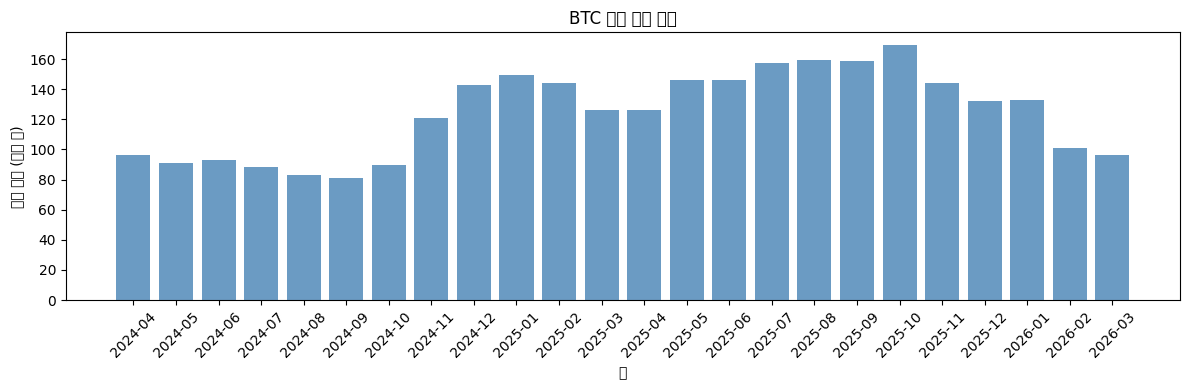

In [14]:
# 월별 평균 종가 차트
plot_df = monthly.sort_values("month")
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(plot_df["month"], plot_df["avg_close"] / 1e6, color="steelblue", alpha=0.8)
ax.set_xlabel("월")
ax.set_ylabel("평균 종가 (백만 원)")
ax.set_title("BTC 월별 평균 종가")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. 윈도우 함수

윈도우 함수는 행을 그룹으로 집계하지 않고,  
각 행에 대해 **주변 행의 값을 참조**할 수 있습니다.

```sql
-- LAG(컬럼, n): n행 이전 값 참조 (전일 종가 등)
LAG(close, 1) OVER (ORDER BY date)

-- AVG() OVER: 이동평균
AVG(close) OVER (ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW)
--                                           ↑ 현재 행 기준 30행(30일) 슬라이딩 윈도우
```

In [15]:
# 일간 수익률 + 이동평균 (MA7, MA30)
df_ma = con.execute("""
    SELECT
        datetime,
        close,

        -- LAG(): 전일 종가를 현재 행에서 참조
        LAG(close, 1) OVER (ORDER BY datetime)  AS prev_close,

        -- 일간 수익률 = (당일 종가 - 전일 종가) / 전일 종가 * 100
        ROUND(
            (close - LAG(close, 1) OVER (ORDER BY datetime))
            / LAG(close, 1) OVER (ORDER BY datetime) * 100,
        2)                                       AS daily_ret_pct,

        -- 7일 이동평균
        ROUND(AVG(close) OVER (
            ORDER BY datetime
            ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
        ), 0)                                    AS ma_7,

        -- 30일 이동평균
        ROUND(AVG(close) OVER (
            ORDER BY datetime
            ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
        ), 0)                                    AS ma_30

    FROM '../data/upbit/KRW-BTC_day.parquet'
    WHERE datetime >= '2023-01-01'
    ORDER BY datetime
""").df()

df_ma.tail(10)

,datetime,close,prev_close,daily_ret_pct,ma_7,ma_30
1146,2026-02-20 09:00:00,99041000.0,98846000.0,0.20,100494286.0,111195233.0
1147,2026-02-21 09:00:00,100162000.0,99041000.0,1.13,100110286.0,110105167.0
1148,2026-02-22 09:00:00,99542000.0,100162000.0,-0.62,99744429.0,109024533.0
1149,2026-02-23 09:00:00,95352000.0,99542000.0,-4.21,98802714.0,107814800.0
1150,2026-02-24 09:00:00,93807000.0,95352000.0,-1.62,97910286.0,106658367.0
1151,2026-02-25 09:00:00,97937000.0,93807000.0,4.40,97812429.0,105607133.0
1152,2026-02-26 09:00:00,97449000.0,97937000.0,-0.50,97612857.0,104532533.0
1153,2026-02-27 09:00:00,96121000.0,97449000.0,-1.36,97195714.0,103433933.0
1154,2026-02-28 09:00:00,97626000.0,96121000.0,1.57,96833429.0,102545233.0
1155,2026-03-01 09:00:00,96610000.0,97626000.0,-1.04,96414571.0,101591900.0


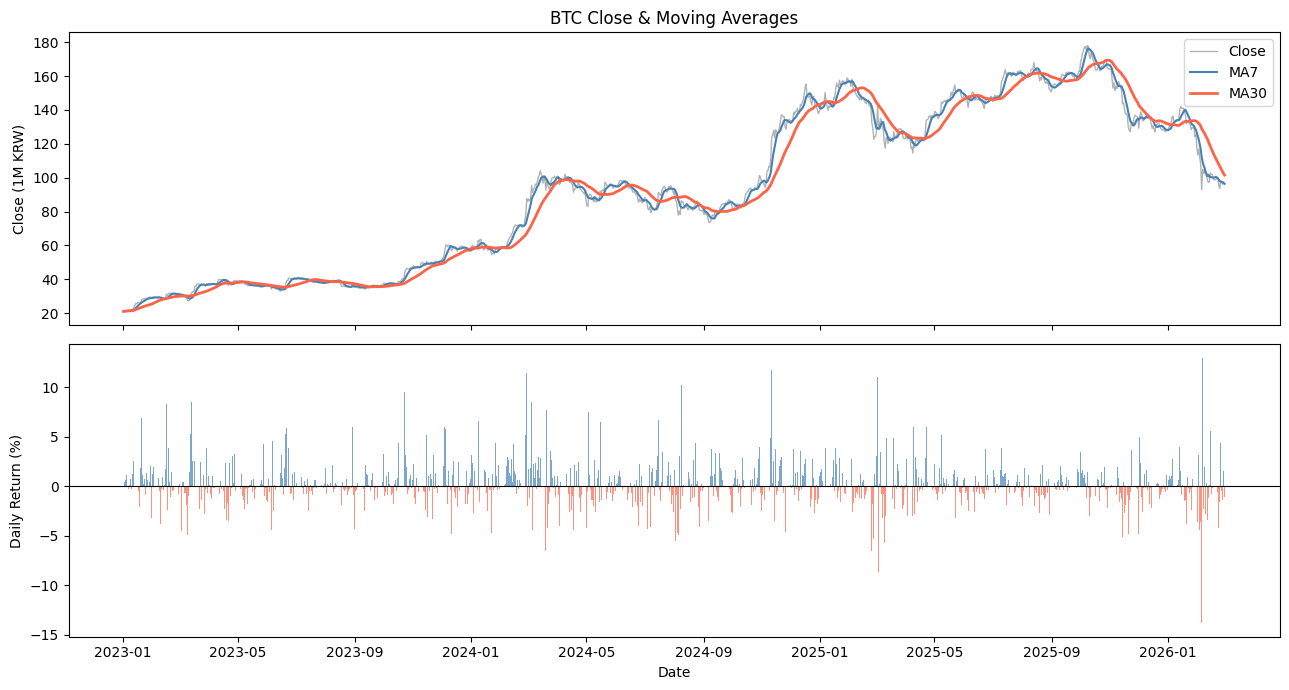

In [23]:
# 종가 + 이동평균 차트
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7), sharex=True)

ax1.plot(df_ma["datetime"], df_ma["close"] / 1e6, lw=1, label="Close", color="gray", alpha=0.6)
ax1.plot(df_ma["datetime"], df_ma["ma_7"] / 1e6, lw=1.5, label="MA7", color="steelblue")
ax1.plot(df_ma["datetime"], df_ma["ma_30"] / 1e6, lw=2, label="MA30", color="tomato")
ax1.set_ylabel("Close (1M KRW)")
ax1.set_title("BTC Close & Moving Averages")
ax1.legend()

colors = df_ma["daily_ret_pct"].apply(lambda x: "tomato" if x < 0 else "steelblue")
ax2.bar(df_ma["datetime"], df_ma["daily_ret_pct"], color=colors, alpha=0.7, width=0.8)
ax2.axhline(0, color="black", lw=0.8)
ax2.set_ylabel("Daily Return (%)")
ax2.set_xlabel("Date")

plt.tight_layout()
plt.show()

## 4. CTE — 변동성 돌파 시그널을 SQL로 구현

CTE(`WITH` 절)는 복잡한 쿼리를 **이름 붙인 중간 단계**로 나눠  
가독성과 재사용성을 높입니다.

```sql
WITH 단계1 AS (
    SELECT ...
),
단계2 AS (
    SELECT ... FROM 단계1   -- 앞 단계를 테이블처럼 참조
)
SELECT * FROM 단계2
```

VBO 진입 조건: `당일 고가 ≥ 시가 + 전일 레인지 × noise_ratio`

In [17]:
NOISE_RATIO = 0.6

df_vbo = con.execute(f"""
    -- 1단계: 전일 레인지 계산
    WITH base AS (
        SELECT
            datetime,
            open,
            high,
            low,
            close,
            LAG(high - low, 1) OVER (ORDER BY datetime) AS prev_range
        FROM '../data/upbit/KRW-BTC_day.parquet'
    ),

    -- 2단계: 목표가 및 진입 시그널
    signals AS (
        SELECT
            datetime,
            open,
            high,
            close,
            prev_range,
            ROUND(open + prev_range * {NOISE_RATIO}, 0)  AS target_price,
            high >= open + prev_range * {NOISE_RATIO}     AS entry_signal
        FROM base
        WHERE prev_range IS NOT NULL
    ),

    -- 3단계: 시그널 발생일에 예상 수익률 계산
    -- 진입가 = 목표가, 청산가 = 다음날 시가 (VBODayExit 방식)
    trades AS (
        SELECT
            datetime,
            target_price                               AS entry_price,
            LEAD(open, 1) OVER (ORDER BY datetime)    AS exit_price,  -- LEAD(): 다음 행 참조
            close,
            entry_signal
        FROM signals
        WHERE entry_signal = TRUE
    )

    SELECT
        datetime,
        entry_price,
        exit_price,
        ROUND((exit_price - entry_price) / entry_price * 100, 2) AS ret_pct
    FROM trades
    WHERE exit_price IS NOT NULL
    ORDER BY datetime DESC
    LIMIT 20
""").df()

df_vbo.head(10)

,datetime,entry_price,exit_price,ret_pct
0,2026-02-25 09:00:00,96064200.0,96120000.0,0.06
1,2026-02-14 09:00:00,101538200.0,93807000.0,-7.61
2,2026-02-08 09:00:00,106742600.0,100799000.0,-5.57
3,2026-02-06 09:00:00,102627800.0,102602000.0,-0.03
4,2026-02-02 09:00:00,117316000.0,92894000.0,-20.82
5,2026-01-28 09:00:00,131219400.0,113416000.0,-13.57
6,2026-01-23 09:00:00,134233800.0,129690000.0,-3.38
7,2026-01-22 09:00:00,133802800.0,132864000.0,-0.70
8,2026-01-18 09:00:00,140681400.0,132505000.0,-5.81
9,2026-01-13 09:00:00,136282000.0,140526000.0,3.11


In [18]:
# 시그널 통계 요약
con.execute(f"""
    WITH base AS (
        SELECT
            datetime,
            open,
            high,
            low,
            LAG(high - low, 1) OVER (ORDER BY datetime) AS prev_range
        FROM '../data/upbit/KRW-BTC_day.parquet'
    ),
    signals AS (
        SELECT
            datetime,
            open,                                              -- trades에서 LEAD(open) 참조용
            open + prev_range * {NOISE_RATIO}          AS target_price,
            high >= open + prev_range * {NOISE_RATIO}   AS entry_signal
        FROM base
        WHERE prev_range IS NOT NULL
    ),
    trades AS (
        SELECT
            datetime,
            target_price,
            LEAD(open, 1) OVER (ORDER BY datetime) AS exit_price,
            entry_signal
        FROM signals
        WHERE entry_signal = TRUE
    )
    SELECT
        COUNT(*)                                                      AS total_trades,
        SUM(CASE WHEN exit_price > target_price THEN 1 ELSE 0 END)   AS wins,
        ROUND(
            SUM(CASE WHEN exit_price > target_price THEN 1 ELSE 0 END)
            * 100.0 / COUNT(*), 1
        )                                                             AS win_rate_pct,
        ROUND(AVG((exit_price - target_price) / target_price * 100), 3) AS avg_ret_pct,
        ROUND(MAX((exit_price - target_price) / target_price * 100), 2) AS best_trade_pct,
        ROUND(MIN((exit_price - target_price) / target_price * 100), 2) AS worst_trade_pct
    FROM trades
    WHERE exit_price IS NOT NULL
""").df()

,total_trades,wins,win_rate_pct,avg_ret_pct,best_trade_pct,worst_trade_pct
0,1020,391.0,38.3,-1.44,19.77,-40.41


## 5. 멀티 티커 분석 — BTC / ETH 상관관계

`JOIN`으로 두 티커 데이터를 날짜 기준으로 합쳐  
상관관계와 연간 변동성을 계산합니다.

```sql
-- USING (date): 두 테이블에 같은 이름의 컬럼(date)으로 JOIN
FROM btc b JOIN eth e USING (date)

-- CORR(): 피어슨 상관계수 (−1 ~ 1)
-- STDDEV() * SQRT(365): 일간 표준편차 → 연간 변동성으로 환산
```

In [19]:
# BTC / ETH 상관관계 및 연간 변동성
con.execute("""
    WITH btc AS (
        SELECT
            datetime,
            close / LAG(close, 1) OVER (ORDER BY datetime) - 1 AS btc_ret
        FROM '../data/upbit/KRW-BTC_day.parquet'
    ),
    eth AS (
        SELECT
            datetime,
            close / LAG(close, 1) OVER (ORDER BY datetime) - 1 AS eth_ret
        FROM '../data/upbit/KRW-ETH_day.parquet'
    ),
    joined AS (
        SELECT b.datetime, b.btc_ret, e.eth_ret
        FROM btc b
        JOIN eth e USING (datetime)
        WHERE b.btc_ret IS NOT NULL AND e.eth_ret IS NOT NULL
    )
    SELECT
        COUNT(*)                                       AS days,
        ROUND(CORR(btc_ret, eth_ret), 4)               AS btc_eth_corr,
        ROUND(STDDEV(btc_ret) * SQRT(365) * 100, 2)   AS btc_ann_vol_pct,
        ROUND(STDDEV(eth_ret) * SQRT(365) * 100, 2)   AS eth_ann_vol_pct,
        ROUND(AVG(btc_ret) * 365 * 100, 2)            AS btc_ann_ret_pct,
        ROUND(AVG(eth_ret) * 365 * 100, 2)            AS eth_ann_ret_pct
    FROM joined
""").df()

,days,btc_eth_corr,btc_ann_vol_pct,eth_ann_vol_pct,btc_ann_ret_pct,eth_ann_ret_pct
0,3076,0.7293,61.77,79.35,55.97,57.68


In [20]:
# 연도별 상관관계 추이 — 시장 국면에 따라 상관관계가 어떻게 변하는지 확인
con.execute("""
    WITH btc AS (
        SELECT
            datetime,
            close / LAG(close, 1) OVER (ORDER BY datetime) - 1 AS btc_ret
        FROM '../data/upbit/KRW-BTC_day.parquet'
    ),
    eth AS (
        SELECT
            datetime,
            close / LAG(close, 1) OVER (ORDER BY datetime) - 1 AS eth_ret
        FROM '../data/upbit/KRW-ETH_day.parquet'
    ),
    joined AS (
        SELECT b.datetime, b.btc_ret, e.eth_ret
        FROM btc b
        JOIN eth e USING (datetime)
        WHERE b.btc_ret IS NOT NULL AND e.eth_ret IS NOT NULL
    )
    SELECT
        strftime(datetime, '%Y')                       AS year,
        COUNT(*)                                       AS days,
        ROUND(CORR(btc_ret, eth_ret), 4)               AS btc_eth_corr,
        ROUND(STDDEV(btc_ret) * SQRT(365) * 100, 1)   AS btc_vol_pct,
        ROUND(STDDEV(eth_ret) * SQRT(365) * 100, 1)   AS eth_vol_pct
    FROM joined
    GROUP BY year
    ORDER BY year
""").df()

,year,days,btc_eth_corr,btc_vol_pct,eth_vol_pct
0,2017,94,0.2631,121.1,105.4
1,2018,365,0.8017,80.0,105.3
2,2019,365,0.7787,63.2,73.3
3,2020,366,0.8030,64.7,88.0
4,2021,365,0.6981,70.8,96.9
5,2022,365,0.8582,53.5,76.0
6,2023,365,0.7723,38.1,40.0
7,2024,366,0.7387,46.6,57.8
8,2025,365,0.7497,35.7,67.2
9,2026,60,0.8875,62.6,79.5


## 6. 노이즈 비율별 전략 성과 비교

VBO의 핵심 파라미터인 `noise_ratio`를 0.3 ~ 0.8 범위에서 SQL로 비교합니다.  
Python 루프와 DuckDB 쿼리를 조합해 파라미터 스윕을 수행합니다.

In [21]:
def vbo_stats_sql(noise_ratio: float) -> dict:
    """noise_ratio별 VBO 전략 통계를 SQL로 계산."""
    row = con.execute(f"""
        WITH base AS (
            SELECT
                datetime,
                open,
                high,
                LAG(high - low, 1) OVER (ORDER BY datetime) AS prev_range
            FROM '../data/upbit/KRW-BTC_day.parquet'
        ),
        trades AS (
            SELECT
                open + prev_range * {noise_ratio}                     AS entry,
                LEAD(open, 1) OVER (ORDER BY datetime)                AS exit_p
            FROM base
            WHERE prev_range IS NOT NULL
              AND high >= open + prev_range * {noise_ratio}
        )
        SELECT
            {noise_ratio}                                                AS noise_ratio,
            COUNT(*)                                                     AS trades,
            ROUND(AVG((exit_p - entry) / entry * 100), 3)               AS avg_ret_pct,
            ROUND(
                SUM(CASE WHEN exit_p > entry THEN 1 ELSE 0 END)
                * 100.0 / COUNT(*), 1
            )                                                            AS win_rate_pct
        FROM trades
        WHERE exit_p IS NOT NULL
    """).fetchone()
    return {"noise_ratio": row[0], "trades": row[1], "avg_ret_pct": row[2], "win_rate_pct": row[3]}


import numpy as np

results = [vbo_stats_sql(r) for r in np.arange(0.3, 0.9, 0.1).round(1)]
df_sweep = pd.DataFrame(results)
df_sweep

,noise_ratio,trades,avg_ret_pct,win_rate_pct
0,0.3,1782,-0.871,38.3
1,0.4,1465,-1.087,37.7
2,0.5,1220,-1.281,37.2
3,0.6,1020,-1.440,38.3
4,0.7,847,-1.585,38.6
5,0.8,717,-1.722,38.9
6,0.9,600,-1.772,39.5


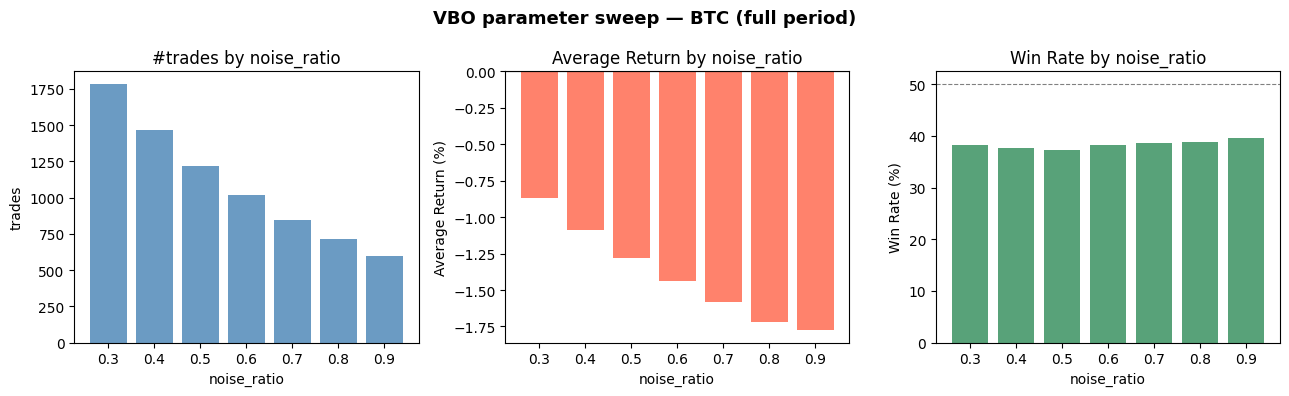

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4))

ax1.bar(df_sweep["noise_ratio"].astype(str), df_sweep["trades"], color="steelblue", alpha=0.8)
ax1.set_title("#trades by noise_ratio")
ax1.set_xlabel("noise_ratio")
ax1.set_ylabel("trades")

ax2.bar(df_sweep["noise_ratio"].astype(str), df_sweep["avg_ret_pct"], color="tomato", alpha=0.8)
ax2.set_title("Average Return by noise_ratio")
ax2.set_xlabel("noise_ratio")
ax2.set_ylabel("Average Return (%)")
ax2.axhline(0, color="black", lw=0.8)

ax3.bar(df_sweep["noise_ratio"].astype(str), df_sweep["win_rate_pct"], color="seagreen", alpha=0.8)
ax3.set_title("Win Rate by noise_ratio")
ax3.set_xlabel("noise_ratio")
ax3.set_ylabel("Win Rate (%)")
ax3.axhline(50, color="gray", lw=0.8, linestyle="--")

plt.suptitle("VBO parameter sweep — BTC (full period)", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()